In [1]:
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.io as sio
from scipy.interpolate import interp1d
import math
from scipy import stats
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import shutil
import os
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 4),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Load data and setup

In [2]:
from analysis_functions import *
from plotting_functions import *

### Define parameters

In [3]:
monkey = 'Stanton'

In [4]:
# PATHS
datapath = 'E:\\two_boundary\\original_data\\'
figpath = 'E:\\two_boundary\\figures\\'
datapathsave = 'E:\\two_boundary\\error_data\\'

brain_areas = ['MT', 'MST', 'LIP', 'SC']

# BRAIN AREAS
#if monkey == 'Neville':
#    brain_areas = ['MT', 'MST', 'LIP']
#else:
#    brain_areas = ['MST', 'LIP']

# BINNING/SMOOTHING PARAMETERS
bins = np.arange(-500, 3051)
sm_std = 40 # gaussian smoothing stdev
bin_size = 100 # msec for binend data

# MIN NUM TRIALS FOR INCLUSION
min_ntrials = 5

# MIN NEURON RATING FOR INCLUSION
min_rating = 2.5

epochs = ['Early sample', 'Late sample', 'Early test']
epoch_indices = {'Early sample': [80, 355], 'Late sample': [355, 630], 'Early test': [DELAY1+100, DELAY1+550]}

## PSTH

In [7]:
n_iter = 20

cat_dec = {}

for area in brain_areas[2:]:
    
    trials_per_dir_all = {}
    
    currpath = datapath + monkey + '\\' + area
    os.chdir(currpath)
    
    figpath_good = figpath + 'psth\\' +  monkey + '\\' + area + '\\' + '\\good_neurons\\'
    figpath_bad = figpath + 'psth\\' +  monkey + '\\' + area + '\\bad_neurons\\'
    datapath_good = datapathsave + monkey + '\\' + area + '\\good_neurons\\'
    datapath_bad = datapathsave + monkey + '\\' + area + '\\bad_neurons\\'
    
    make_dirs(figpath_good)
    make_dirs(figpath_bad)
    make_dirs(datapath_good)
    make_dirs(datapath_bad)
    
    filelist = [f for f in glob.glob("*merged_w_ratings.mat")]
    n_files = len(filelist)
    
    # Pre-allocate
    all_ratings = []
    mean_firing_rates = []
    
    cat_dec[area] = {'Early sample': {}, 'Late sample': {}, 'Early test': {}, 'rCTI': {}}
    
    currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
    data = sio.loadmat(currdatapath)
    rCTI_all = data['rCTI_all'][area][0][0]
    neuron_names = os.listdir('E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\')[:-1]
    neuron_names = [i[:-4] for i in neuron_names]
    
    cat_dec[area]['name'] = []
    
    for epoch in epochs:
        cat_dec[area][epoch]['correct'] = []
        cat_dec[area][epoch]['error'] = []
        
    # Loop over files (datasets)
    for file in filelist:
        bhv = sio.loadmat(file)['data']['BHV'] # data from monkeylogic bhv files
        neuro = sio.loadmat(file)['data']['NEURO'] # data from neural nex file   

        date = file[8:18] # date of recording session
        
        conditions = bhv[0][0][0][0][3][0] # list of conditions per trial
        errors = bhv[0][0][0][0][5] # list of errors per trial
        code_times = [i[0] for i in neuro[0][0][0][0][2]] # list of code times for each trial
        code_numbers = [i[0] for i in neuro[0][0][0][0][3]] # list of code numbers for each trial

        trial_starts = [i for i, val in enumerate(code_numbers) if val == STRT_TRIAL]

        n_neurons = len(neuro[0][0][0][0][1][0][0]) # list of all neurons from session

        # Loop over neurons
        for i_neuron in range(n_neurons):
            neuron_name = neuro[0][0][0][0][1][0][0].dtype.names[i_neuron]
            
            # If neuron is task-responsive
            if path.exists('E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\' + date + '_' + neuron_name + '.mat'):
            
                spikes = [i[0] for i in neuro[0][0][0][0][1][0][0][i_neuron]] # array of spike times (relative to session start)    
                [raw_spikes, mean_psth_raw, mean_psth_sm, binned_spikes, trials_per_dir] = get_psth_error(spikes, errors, trial_starts, conditions, code_numbers, code_times, bins, sm_std, bin_size)
                
                nt_c1 = sum([len(binned_spikes[i]) for i in range(int(N_CONDS_DMC/2))])
                nt_c2 = sum([len(binned_spikes[i]) for i in range(int(N_CONDS_DMC/2), N_CONDS_DMC)])
                
                if (nt_c1 > 5) and (nt_c2 > 5): 

                    error_by_cat = org_data_by_cat(binned_spikes)
                    #error_by_dir = org_data_by_dir(mean_psth_sm)
                    
                    fname_fig = 'E:\\two_boundary\\figures\\error_psth\\' + date + '_' + neuron_name + '.png'
                    #plot_psth(mean_psth_sm, bins[0:-1], fname_fig, sm_std)

                    corr_trials_file = 'E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\' + date + '_' + neuron_name + '.mat'
                    data_by_cond = sio.loadmat(corr_trials_file)['binned_spikes'].flatten()
                    data_by_cat = org_data_by_cat(data_by_cond)     
                    
                    cat_dec[area]['name'].append(date + '_' + neuron_name)

                    for epoch in epoch_indices:
                        indx1 = np.where(bins >= epoch_indices[epoch][0])[0][0]
                        indx2 = np.where(bins >= epoch_indices[epoch][1])[0][0] 

                        window_cat = ([(np.mean(data_by_cat[i][:, indx1:indx2], 1)) for i in range(2)])
                        window_cat_err = ([(np.mean(error_by_cat[i][:, indx1:indx2], 1)) for i in range(2)])
                        
                        min_nt_corr = min([len(window_cat[0]), len(window_cat[1])])
                        min_nt_err = min([len(window_cat_err[0]), len(window_cat_err[1])])
                        
                        corr_perf = np.zeros(n_iter)
                        err_perf = np.zeros(n_iter)
                        
                        for iteration in range(n_iter):
                        
                            i0 = np.random.choice(len(window_cat[0][:]), min_nt_corr, replace = False)
                            i1 = np.random.choice(len(window_cat[1][:]), min_nt_corr, replace = False)

                            x_corr_all = np.hstack([window_cat[0][i0], window_cat[1][i1]])
                            y = np.hstack([np.zeros(min_nt_corr), np.ones(min_nt_corr)])

                            sss = StratifiedShuffleSplit(n_splits = 1, test_size = min_nt_err*2)
                            for train_index, test_index in sss.split(x_corr_all, y):
                                Xtrain, Xtest_corr = x_corr_all[train_index], x_corr_all[test_index]
                                ytrain, ytest_corr = y[train_index], y[test_index]

                            Xtrain = Xtrain.reshape(-1, 1)
                            Xtest_corr = Xtest_corr.reshape(-1, 1)

                            i0 = np.random.choice(len(window_cat_err[0][:]), min_nt_err, replace = False)
                            i1 = np.random.choice(len(window_cat_err[1][:]), min_nt_err, replace = False)

                            y_test_err = np.hstack([np.zeros(min_nt_err), np.ones(min_nt_err)])
                            x_test_err = np.hstack([window_cat_err[0][i0], window_cat_err[1][i1]])
                            x_test_err = x_test_err.reshape(-1, 1)

                            clf = SVC(kernel='linear')
                            clf.fit(Xtrain, ytrain)

                            pred = clf.predict(Xtest_corr)
                            corr_perf[iteration] = sum(pred == ytest_corr)/len(ytest_corr)*100                             

                            pred = clf.predict(x_test_err)                
                            err_perf[iteration] = sum(pred == y_test_err)/len(y_test_err)*100
                            
                        cat_dec[area][epoch]['correct'].append(np.mean(corr_perf))
                        cat_dec[area][epoch]['error'].append(np.mean(err_perf))
                        

                        #if cat_dec[area][epoch]['error'][-1] > 65 and cat_dec[area][epoch]['correct'][-1] < 60:

                            #indx1 = np.where(np.arange(bins[0], bins[-1], 10) >= epoch_indices[epoch][0])[0][0]
                            #indx2 = np.where(np.arange(bins[0], bins[-1], 10) >= epoch_indices[epoch][1])[0][0]

                            #curr_indx = [i for i, s in enumerate(neuron_names) if s == date + '_' + neuron_name]
                            #cat_dec[area]['rCTI'][epoch].append(np.mean(rCTI_all[curr_indx, indx1:indx2]))


In [9]:
'''
n_iter = 200

cat_dec = {}

for area in brain_areas[2:]:
    
    trials_per_dir_all = {}
    
    currpath = datapath + monkey + '\\' + area
    os.chdir(currpath)
    
    figpath_good = figpath + 'psth\\' +  monkey + '\\' + area + '\\' + '\\good_neurons\\'
    figpath_bad = figpath + 'psth\\' +  monkey + '\\' + area + '\\bad_neurons\\'
    datapath_good = datapathsave + monkey + '\\' + area + '\\good_neurons\\'
    datapath_bad = datapathsave + monkey + '\\' + area + '\\bad_neurons\\'
    
    make_dirs(figpath_good)
    make_dirs(figpath_bad)
    make_dirs(datapath_good)
    make_dirs(datapath_bad)
    
    filelist = [f for f in glob.glob("*merged_w_ratings.mat")]
    n_files = len(filelist)
    
    # Pre-allocate
    all_ratings = []
    mean_firing_rates = []
    
    cat_dec[area] = {'Early sample': {}, 'Late sample': {}, 'Early test': {}, 'rCTI': {}}
    
    currdatapath = figpath + 'rCTI\\' + monkey + '_rCTI.mat'
    data = sio.loadmat(currdatapath)
    rCTI_all = data['rCTI_all'][area][0][0]
    neuron_names = os.listdir('E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\')[:-1]
    neuron_names = [i[:-4] for i in neuron_names]
    
    cat_dec[area]['name'] = []
    
    for epoch in epochs:
        cat_dec[area][epoch]['correct'] = []
        cat_dec[area][epoch]['error'] = []
        
    # Loop over files (datasets)
    for file in filelist:
        bhv = sio.loadmat(file)['data']['BHV'] # data from monkeylogic bhv files
        neuro = sio.loadmat(file)['data']['NEURO'] # data from neural nex file   

        date = file[8:18] # date of recording session
        
        conditions = bhv[0][0][0][0][3][0] # list of conditions per trial
        errors = bhv[0][0][0][0][5] # list of errors per trial
        code_times = [i[0] for i in neuro[0][0][0][0][2]] # list of code times for each trial
        code_numbers = [i[0] for i in neuro[0][0][0][0][3]] # list of code numbers for each trial

        trial_starts = [i for i, val in enumerate(code_numbers) if val == STRT_TRIAL]

        n_neurons = len(neuro[0][0][0][0][1][0][0]) # list of all neurons from session

        # Loop over neurons
        for i_neuron in range(n_neurons):
            neuron_name = neuro[0][0][0][0][1][0][0].dtype.names[i_neuron]
            
            # If neuron is task-responsive
            if path.exists('E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\' + date + '_' + neuron_name + '.mat'):
            
                spikes = [i[0] for i in neuro[0][0][0][0][1][0][0][i_neuron]] # array of spike times (relative to session start)    
                [raw_spikes, mean_psth_raw, mean_psth_sm, binned_spikes, trials_per_dir] = get_psth_error(spikes, errors, trial_starts, conditions, code_numbers, code_times, bins, sm_std, bin_size)
                
                nt_c1 = sum([len(binned_spikes[i]) for i in range(int(N_CONDS_DMC/2))])
                nt_c2 = sum([len(binned_spikes[i]) for i in range(int(N_CONDS_DMC/2), N_CONDS_DMC)])
                
                if (nt_c1 > 5) and (nt_c2 > 5): 

                    error_by_cat = org_data_by_cat(binned_spikes)
                    #error_by_dir = org_data_by_dir(mean_psth_sm)
                    
                    fname_fig = 'E:\\two_boundary\\figures\\error_psth\\' + date + '_' + neuron_name + '.png'
                    #plot_psth(mean_psth_sm, bins[0:-1], fname_fig, sm_std)

                    corr_trials_file = 'E:\\two_boundary\\data\\' + monkey + '\\' + area + '\\good_neurons\\task_responsive\\' + date + '_' + neuron_name + '.mat'
                    data_by_cond = sio.loadmat(corr_trials_file)['binned_spikes'].flatten()
                    data_by_cat = org_data_by_cat(data_by_cond)     
                    
                    cat_dec[area]['name'].append(date + '_' + neuron_name)

                    for epoch in epoch_indices:
                        indx1 = np.where(bins >= epoch_indices[epoch][0])[0][0]
                        indx2 = np.where(bins >= epoch_indices[epoch][1])[0][0] 

                        window_cat = ([(np.mean(data_by_cat[i][:, indx1:indx2], 1)) for i in range(2)])
                        window_cat_err = ([(np.mean(error_by_cat[i][:, indx1:indx2], 1)) for i in range(2)])
                        
                        min_nt_corr = min([len(window_cat[0]), len(window_cat[1])])
                        min_nt_err = min([len(window_cat_err[0]), len(window_cat_err[1])])
                        
                        corr_perf = np.zeros(n_iter)
                        err_perf = np.zeros(n_iter)
                        
                        for iteration in range(n_iter):
                        
                            i0 = np.random.choice(len(window_cat[0][:]), min_nt_corr, replace = False)
                            i1 = np.random.choice(len(window_cat[1][:]), min_nt_corr, replace = False)

                            x_corr_all = np.hstack([window_cat[0][i0], window_cat[1][i1]])
                            y = np.hstack([np.zeros(min_nt_corr), np.ones(min_nt_corr)])

                            sss = StratifiedShuffleSplit(n_splits = 1, test_size = min_nt_err*2)
                            for train_index, test_index in sss.split(x_corr_all, y):
                                Xtrain, Xtest_corr = x_corr_all[train_index], x_corr_all[test_index]
                                ytrain, ytest_corr = y[train_index], y[test_index]

                            Xtrain = Xtrain.reshape(-1, 1)
                            Xtest_corr = Xtest_corr.reshape(-1, 1)

                            i0 = np.random.choice(len(window_cat_err[0][:]), min_nt_err, replace = False)
                            i1 = np.random.choice(len(window_cat_err[1][:]), min_nt_err, replace = False)

                            y_test_err = np.hstack([np.zeros(min_nt_err), np.ones(min_nt_err)])
                            x_test_err = np.hstack([window_cat_err[0][i0], window_cat_err[1][i1]])
                            x_test_err = x_test_err.reshape(-1, 1)

                            clf = SVC(kernel='linear')
                            clf.fit(Xtrain, ytrain)

                            pred = clf.predict(Xtest_corr)
                            corr_perf[iteration] = sum(pred == ytest_corr)/len(ytest_corr)*100                             

                            pred = clf.predict(x_test_err)                
                            err_perf[iteration] = sum(pred == y_test_err)/len(y_test_err)*100
                            
                        cat_dec[area][epoch]['correct'].append(np.mean(corr_perf))
                        cat_dec[area][epoch]['error'].append(np.mean(err_perf))
                        

                        #if cat_dec[area][epoch]['error'][-1] > 65 and cat_dec[area][epoch]['correct'][-1] < 60:

                            #indx1 = np.where(np.arange(bins[0], bins[-1], 10) >= epoch_indices[epoch][0])[0][0]
                            #indx2 = np.where(np.arange(bins[0], bins[-1], 10) >= epoch_indices[epoch][1])[0][0]

                            #curr_indx = [i for i, s in enumerate(neuron_names) if s == date + '_' + neuron_name]
                            #cat_dec[area]['rCTI'][epoch].append(np.mean(rCTI_all[curr_indx, indx1:indx2]))
'''

In [434]:
cat_dec['LIP']['name']

['20180801_1_sig001a',
 '20180823_1_sig001a',
 '20180827_1_sig001a',
 '20180828_1_sig001a',
 '20180829_1_sig001a',
 '20180905_1_sig002a',
 '20180905_1_sig002b',
 '20180905_1_sig003a',
 '20180905_1_sig004a',
 '20180905_1_sig007a',
 '20180905_1_sig012a',
 '20180905_1_sig015a',
 '20180905_1_sig015c',
 '20180906_3_sig005a',
 '20180906_3_sig007a',
 '20180910_1_sig003a',
 '20180910_1_sig003b',
 '20180910_1_sig008a',
 '20180910_1_sig014a',
 '20180910_1_sig014b',
 '20180911_1_sig001a',
 '20180911_1_sig003a',
 '20180911_1_sig007a',
 '20180911_1_sig015a',
 '20180911_1_sig015b',
 '20180925_1_sig005a',
 '20180925_1_sig006a',
 '20180925_1_sig007a',
 '20180925_1_sig008a',
 '20180925_1_sig011a',
 '20180925_1_sig012a',
 '20180926_1_sig007a',
 '20180926_1_sig015a',
 '20180926_1_sig016a',
 '20180927_1_sig001a',
 '20180927_1_sig002a',
 '20180927_1_sig004a',
 '20180927_1_sig005a',
 '20180927_1_sig008a',
 '20180927_1_sig009a',
 '20180927_1_sig011a',
 '20180928_1_sig001a',
 '20180928_1_sig001b',
 '20180928_

In [440]:
i = 10
print(cat_dec['LIP']['Early sample']['correct'][i])
print(cat_dec['LIP']['Early sample']['error'][i])

54.7734375
44.7890625


In [443]:
cat_dec[area][comparison[0]]['correct']

[63.13541666666666,
 50.89492753623188,
 56.24305555555556,
 60.43181818181818,
 59.0,
 78.34375,
 72.25,
 52.984375,
 68.0390625,
 55.4921875,
 76.3515625,
 56.694444444444436,
 58.3515625,
 49.3875,
 53.4125,
 52.263888888888886,
 50.25,
 61.15277777777777,
 59.40277777777777,
 53.625,
 51.273809523809526,
 56.392857142857146,
 51.5625,
 51.04166666666666,
 58.66666666666666,
 50.72058823529412,
 57.3235294117647,
 53.36764705882353,
 59.91176470588236,
 59.41176470588236,
 55.31818181818182,
 49.75,
 61.24999999999999,
 64.9090909090909,
 56.61363636363636,
 55.75,
 51.30952380952382,
 55.875,
 53.32142857142857,
 54.89772727272728,
 53.48809523809525,
 56.65625,
 55.6875,
 48.375,
 46.84375,
 55.78125,
 51.25,
 58.61111111111111,
 53.75,
 60.72916666666666,
 59.79166666666666,
 67.77083333333334,
 47.861111111111114,
 49.83333333333333,
 52.02083333333334,
 55.722222222222214,
 64.16666666666666,
 47.83333333333334,
 55.85416666666666,
 52.20833333333333,
 52.45833333333333,
 52.21

76

In [8]:
comparisons = [('Early sample', 'Early sample'),
 ('Late sample', 'Late sample'),
 ('Early test', 'Early test')]

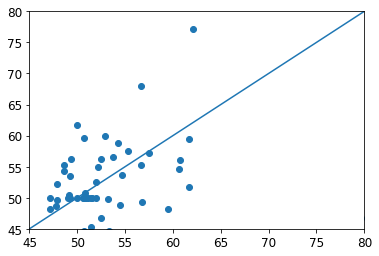

In [10]:
plt.scatter(cat_dec[area]['Early test']['correct'], cat_dec[area]['Early test']['error'])

plt.xlim(45, 80)
plt.ylim(45, 80)
plt.plot([45, 80], [45, 80])

20.0
18.333333333333332
25.0


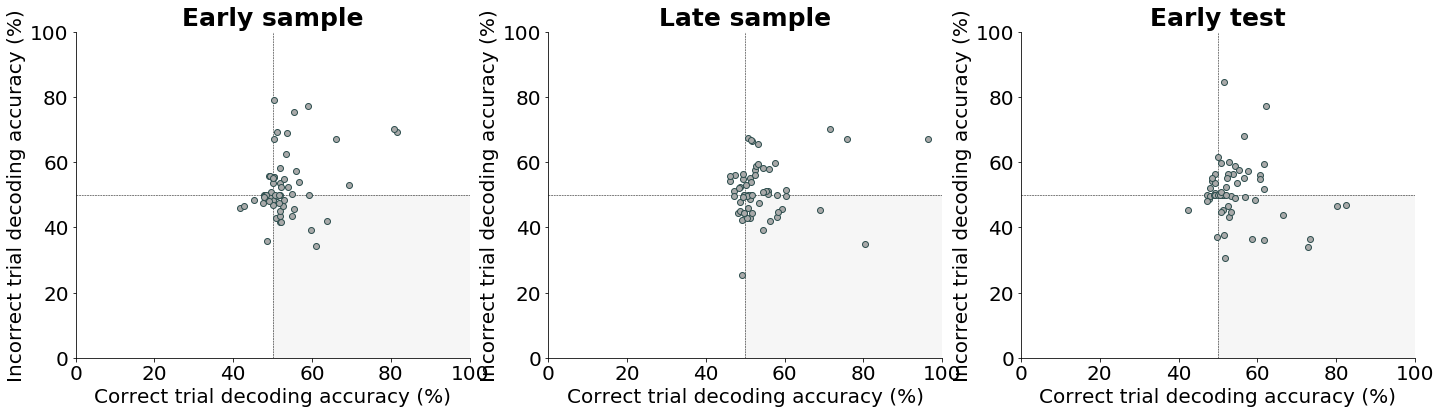

In [11]:
fig, ax =  plt.subplots(1, 3, figsize=(24, 6))

area = 'SC'
#comparisons = list(itertools.combinations(epochs, 2))

for i, comparison in enumerate(comparisons):

    r = round(np.corrcoef(cat_dec[area][comparison[0]]['correct'], cat_dec[area][comparison[1]]['error'])[0][1], 3)
    ax[i].fill([50, 100, 100, 50], [0, 0, 50, 50], alpha = 0.2, color = 'lightgrey', zorder=1)
    #ax[i].scatter(cat_dec[area][comparison[0]]['correct'], cat_dec[area][comparison[1]]['error'], edgecolor = 'darkslategrey', facecolor = 'darkgrey', label = 'R = {}'.format(r))
    ax[i].scatter(cat_dec[area][comparison[0]]['correct'], cat_dec[area][comparison[1]]['error'], edgecolor = 'darkslategrey', facecolor = 'darkgrey', zorder = 20)
    ax[i].plot([0, 100], [50, 50], '--k', lw = 0.5, zorder = 1)
    ax[i].plot([50, 50], [0, 100], '--k', lw = 0.5, zorder = 1)
    #ax[i].plot([0, 100], [0, 100], '--k', lw = 0.5, zorder = 1)
    print(len([val for i, val in enumerate(cat_dec[area][comparison[0]]['correct']) if val > 51 and cat_dec[area][comparison[0]]['error'][i] < 49])/len(cat_dec[area][comparison[0]]['correct'])*100)
    
    
    ax[i].set_xlabel('Correct trial decoding accuracy (%)', fontsize = 20)
    ax[i].set_ylabel('Incorrect trial decoding accuracy (%)', fontsize = 20)
    ax[i].set_title(comparison[0], fontsize = 25, fontweight='bold')

    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(0, 100)
    ax[i].tick_params(labelsize=20)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].legend(frameon = False, fontsize = 20, loc = 'upper right')

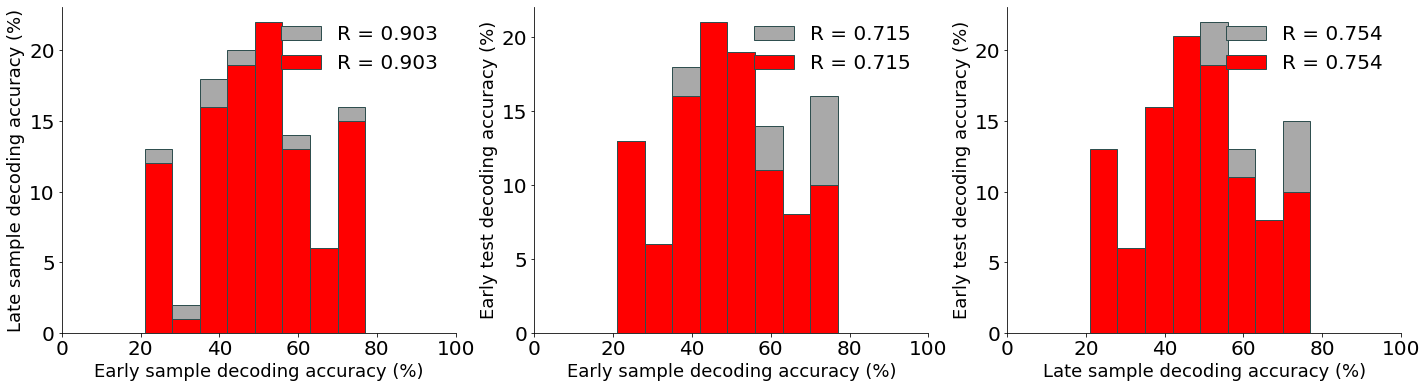

In [373]:
fig, ax =  plt.subplots(1, 3, figsize=(24, 6))

comparisons = list(itertools.combinations(epochs, 2))

for i, comparison in enumerate(comparisons):

    r = round(np.corrcoef(cat_dec[comparison[0]], cat_dec[comparison[1]])[0][1], 3)
    ax[i].hist(cat_dec[comparison[0]], bins = np.arange(0, 100, 5), edgecolor = 'darkslategrey', facecolor = 'darkgrey', label = 'R = {}'.format(r))
    ax[i].hist(cat_dec[comparison[1]], bins = np.arange(0, 100, 5), edgecolor = 'darkslategrey', facecolor = 'r', label = 'R = {}'.format(r))
    ax[i].set_xlabel(comparison[0] + ' decoding accuracy (%)', fontsize = 18)
    ax[i].set_ylabel(comparison[1] + ' decoding accuracy (%)', fontsize = 18)

    ax[i].set_xlim(0, 100)
    #ax[i].set_ylim(0, 100)
    ax[i].tick_params(labelsize=20)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].legend(frameon = False, fontsize = 20, loc = 'upper right')

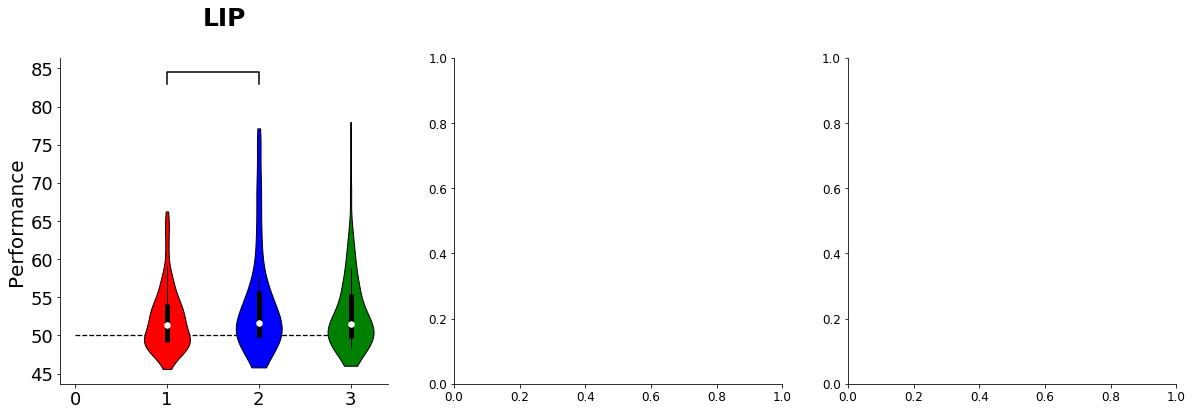

In [386]:
violin_colors = {'Early sample': 'r', 'Late sample': 'b', 'Early test': 'g'}
violin_colors = ['r', 'b', 'g']

chance_level = 50
area = 'LIP'

fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
x1, x2, x3 = 1, 2, 3

i = 0
data = [cat_dec[area]['Early sample']['correct'], cat_dec[area]['Late sample']['correct'], cat_dec[area]['Early test']['correct']]

parts = ax[i].violinplot(data, showmeans=False, showmedians=False, showextrema=False)
for ii, pc in enumerate(parts['bodies']):
    pc.set_facecolor(violin_colors[ii])
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax[i].scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax[i].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax[i].vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

ax[i].set_title(area, fontsize = 25, y = 1.08, fontweight='bold')

ax[i].plot([0, 3], [chance_level, chance_level], '--k', lw = 1.3, zorder = 0)
ax[i].tick_params(labelsize = 18)

#curr_pval = input_data['pvals'][area]
#sigtext = get_sigtext(curr_pval)

if abs(np.max(data) + 5)-50 > 5:
    y = np.max(data) + 5
else:
    y = 55

h, col = 1.5, 'k'
ax[i].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#ax[i].text((x1+x2)*.5, y+h, sigtext, ha='center', va='bottom', color=col, fontsize = 20)

# Hide the right and top spines
for i in range(3):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    #ax[i].set_ylim(0, 0.0016)

ax[0].set_ylabel('Performance', fontsize = 20)

#ax[0].set_ylim(ylim)
#ax[1].set_ylim(ylim)
#ax[2].set_ylim(ylim)

# set style for the axes
#labels = ['DMC', 'PV']
#for ax in [ax[0], ax[1], ax[2]]:
#    set_axis_style(ax, labels)

plt.show()

#for i in save_filetype:
    #savename = savepath + i
    #fig.savefig(savename, bbox_inches='tight')

In [6]:
def get_psth_error(spikes, errors, trial_starts, conditions, code_numbers, code_times, bins, std = 30, bin_size = 1):

    spikes = np.array(spikes)

    n_conds = 72

    raw_spikes = [[] for i in range(n_conds)]
    psth_binned = [[] for i in range(n_conds)]
    n_trials = len(conditions)


    for i_trial in range(n_trials):

        condition_num = conditions[i_trial]-1
        dir_num = int(np.ceil(condition_num/6))-1
        cat_num = int(np.floor(condition_num/37))

        trial_start_indx = trial_starts[i_trial]
        trial_start_time = code_times[trial_start_indx]

        if errors[i_trial] == 6 and condition_num != PV_COND and code_numbers[trial_start_indx+1] != MS_STIM_ON and code_numbers[trial_start_indx+1] != 1:

            if trial_start_time > spikes[0] and trial_start_time < spikes[-1]:

                if i_trial != n_trials-1:
                    samp_on_indx = [i+trial_start_indx for i, val in enumerate(code_numbers[trial_start_indx:trial_starts[i_trial+1]]) if val == SAMP_ON][0]
                else:
                    samp_on_indx = [i+trial_start_indx for i, val in enumerate(code_numbers[trial_start_indx:]) if val == SAMP_ON][0]
                samp_on_time = code_times[samp_on_indx]

                t1 = spikes[spikes > samp_on_time-abs(bins[0])]
                t2 =  spikes[spikes < samp_on_time+(bins[-1]+1)]
                spike_times = np.intersect1d(t1, t2) - samp_on_time

                binned = np.histogram(spike_times, bins)[0]
                raw_spikes[condition_num].append(binned)

                psth_binned[condition_num].append(np.convolve(binned, np.ones(bin_size), 'same'))

    mean_psth = np.zeros([n_conds, len(bins)-1])
    for i, curr_spikes in enumerate(raw_spikes):
        mean_psth[i] = np.mean(curr_spikes, 0)*1000

    n_timepoints = np.shape(mean_psth)[1]

    mean_psth_sm = np.zeros([n_conds, n_timepoints])
    for i_cond, curr_spikes in enumerate(mean_psth):
        mean_psth_sm[i_cond] = gaussian_filter1d(mean_psth[i_cond], std)

    trials_per_dir = np.zeros(N_DIRS)
    for i, val in enumerate(np.arange(0, 72, 6)):
        if len([ii for ii in raw_spikes[val:val+6] if len(ii)> 0]) > 0:
            trials_per_dir[i] = len(np.vstack([ii for ii in raw_spikes[val:val+6] if len(ii)> 0]))
        else:
            trials_per_dir[i] = 0

    return raw_spikes, mean_psth, mean_psth_sm, psth_binned, trials_per_dir